Tasks
1. Data Retrieval and Preprocessing
- Obtain MovieLens 1M dataset. []
- Load dataset. []
- Check data integrity: []
- Address issues like missing movies. []
- Handle data inconsistencies (e.g., user IDs with additional data, ratings for non-existent movies). []
- Create User-Item Interaction Matrix. []
- Split data for 5-fold cross-validation. []
- Handling Cold Starts (dealing with users or items not seen during training). []
2. Recommendation Algorithms
- Implement Naive Approaches: []
- Global Average Rating. []
- Average Rating per Item. []
- Average Rating per User. []
- Optimal Linear Combination with and without bias. []
- Implement UV Matrix Decomposition. []
- Implement Matrix Factorization with Gradient Descent and Regularization. []
- For each algorithm, calculate: 
- RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error). []
- Address Cold Starts for the implemented algorithms. []
3. Visualization
- Apply dimensionality reduction techniques for visualization: []
- PCA (Principal Component Analysis). []
- t-SNE (t-Distributed Stochastic Neighbor Embedding). []
- UMAP (Uniform Manifold Approximation and Projection). []
4. Documentation and Reporting 
- Document code, algorithms, and preprocessing steps. []
- Summarize and analyze the results of each algorithm. []
- Provide insights into the best-performing algorithms. []
- Discuss challenges and limitations encountered during the implementation. []

In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.linear_model import LinearRegression

## Data retrival

Transform 2 datasets, one containing users the other cotaining movies to pandas dataframe

In [2]:
# Loading data sets

# movies
df_movies = pd.read_csv("ml-1m/movies.dat", sep='::', encoding='ISO-8859-1', header=None, engine='python', names=['MovieID', 'Title', 'Genres'])
df_movies = df_movies.rename({0: 'MovieID', 1: 'Title', 2: 'Genre'}, axis='columns')

#ratings
df_ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', encoding='ISO-8859-1', header=None, engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

#users
df_users = pd.read_csv("ml-1m/users.dat", sep='::', encoding='ISO-8859-1', header=None, engine="python", names=['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'])
df_users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode']




In [16]:
# Check for missing values in ratings dataset
df_ratings.isnull().sum()

# Check for missing values in movies dataset
df_movies.isnull().sum()

# Check for missing values in users dataset
df_users.isnull().sum()



UserID        0
Gender        0
Age           0
Occupation    0
ZipCode       0
dtype: int64

In [3]:


# In movies.dat there is missing movieID of 91 we create a placeholder
new_movie = pd.DataFrame({'MovieID': [91], 'Title': ['Unknown'], 'Genres': ['Unknown']})
df_movies = pd.concat([df_movies, new_movie], ignore_index=True)

# Merging movies and ratings DataFrames based on MovieID
merged_df = pd.merge(df_ratings, df_movies, on='MovieID')

# Merging the resulting DataFrame with users DataFrame based on UserID
final_merged_df = pd.merge(merged_df, df_users, on='UserID')

# Print the merged DataFrame
print(final_merged_df.head())


   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
   UserID Gender  Age  Occupation ZipCode
0       1      F    1          10   48067
1       2      M   56          16   70072
2       3      M   25          15   55117
3       4      M   45           7   02460
4       5      M   25          20   55455
   UserID  MovieID  Rating  Timestamp                     

# Recommendations algorithms

## Naive Approach

For the naive algorithm, first calculate R_item and R_user which represent the average ratings from the training set for a user and a movie respectively, thereafter, find the users and movies that are not represented in the training set, and set their R_item and R_user to the global average of the trianing set. Perform linear regression on the training set and test on the test set.

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def Naive_1(train_df, test_df):
    # Naive Approach
    r_item = train_df.groupby('MovieID')['Rating'].mean().reset_index().rename({'Rating':
                                                                    'R_item'},axis='columns')

    r_user = train_df.groupby('UserID')['Rating'].mean().reset_index().rename({'Rating':
                                                                    'R_user'},axis='columns')

    train_df=train_df.merge(r_item, on=['MovieID']).merge(r_user, on=['UserID'])

    #Handle instances were we do not have instances in the training set of movies/users in test set
    test_df=test_df.merge(r_item, on=['MovieID']).merge(r_user, on=['UserID'])
    test_only_users = set(test_df['UserID']) - set(train_df['UserID'])
    test_only_movies = set(test_df['MovieID']) - set(train_df['MovieID'])
    global_average_rating = train_df['Rating'].mean()
    for user in test_only_users:
        test_df.loc[test_df['user_id'] == user, 'R_user'] = global_average_rating

    for movie in test_only_movies:
        test_df.loc[test_df['movie_id'] == movie, 'R_item'] = global_average_rating


    X = train_df[['R_item','R_user']]
    y = train_df['Rating']
    model = LinearRegression().fit(X, y)

    alpha, beta = model.coef_
    gamma = model.intercept_

    X_test = test_df[['R_item','R_user']]
    y_test = test_df["Rating"]

    # Predict ratings for the test set
    y_pred = model.predict(X_test)

    # Calculate the root mean squared error (RMSE) for the predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Calculate the mean absolute error (MAE) for the predictions
    mae = mean_absolute_error(y_test, y_pred)

    # Print the coefficients and RMSE
    print(f"Alpha: {alpha}, Beta: {beta}, Gamma: {gamma}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    return train_df, test_df

K-fold cross validation, get 5 different test set to measure recommender system performance

In [40]:
# Ratins into 5

num_folds = 5

# Kfold object to split data into
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Convert the DataFrame to a list to ensure consistent indices
ratings_data = final_merged_df.values

# Split the data into 5 folds
for fold, (train_indices, test_indices) in enumerate(kf.split(ratings_data)):
    # Split the ratings dataset
    train_ratings = df_ratings.iloc[train_indices]
    test_ratings = df_ratings.iloc[test_indices]
    Naive_1(train_ratings, test_ratings)
    print(f"Fold {fold + 1} - Train Ratings: {len(train_ratings)}, Test Ratings: {len(test_ratings)}")


Alpha: 0.8740965902013323, Beta: 0.7810745880335607, Gamma: -2.3463955916195687
Root Mean Squared Error: 0.9286138582566785
Mean Absolute Error: 0.7370310204973358
Fold 1 - Train Ratings: 800167, Test Ratings: 200042
Alpha: 0.8753418319259971, Beta: 0.7828465528997295, Gamma: -2.356804780842453
Root Mean Squared Error: 0.9221162250124191
Mean Absolute Error: 0.7305036813307719
Fold 2 - Train Ratings: 800167, Test Ratings: 200042
Alpha: 0.8751552250494812, Beta: 0.7827805198696646, Gamma: -2.3570841789283365
Root Mean Squared Error: 0.9219191391230723
Mean Absolute Error: 0.7306165962049215
Fold 3 - Train Ratings: 800167, Test Ratings: 200042
Alpha: 0.8748411073383846, Beta: 0.7816435808416614, Gamma: -2.3513302691593383
Root Mean Squared Error: 0.9240170675815428
Mean Absolute Error: 0.7323167575293639
Fold 4 - Train Ratings: 800167, Test Ratings: 200042
Alpha: 0.8749433445637776, Beta: 0.7811647681925113, Gamma: -2.3498424387928014
Root Mean Squared Error: 0.9247226313559603
Mean Abso

## Naive approach

In [32]:

    def matrix_factorization(self, train_df, test_df):
        # The Matrix Factorization

        num_factors=10
        num_iter=75
        reg=0.05
        lr=0.005
        num_users = df_ratings['UserID'].nunique()
        num_movies = df_ratings['MovieID'].nunique()
        
        U = np.random.rand(num_users, num_factors)
        V = np.random.rand(num_movies, num_factors).T
        R = pd.pivot_table(train_df, index='UserID', columns='MovieID', values='Rating').values
        for i in range(num_iter):
            for i in range(num_users):
                for j in range(num_movies):
                    error = R[i][j] -  np.dot(U[i, :], V[:, j])
                    for k in range(num_factors):
                        U[i][k] += lr * (error * V[k][j] - reg*  U[i][k])
                        V[k][j] += lr * (error * U[i][k] - reg*  V[k][j])
            # Compute loss
            total_error = 0
            for i in range(num_users):
                for j in range(num_movies):
                    if R[i][j] > 0:
                        total_error += (R[i][j] - np.dot(U[i, :], V[:, j]))**2

            print(f"Total Training Error epoch {e}: {total_error}")
       # Test the model on the test set and compute the RMSE
            test_matrix = pd.pivot_table(test_df, index='UserID', columns='MovieID', values='Rating').values
            test_error = 0
            count = 0
            
            for i in range(num_users):
                for j in range(num_movies):
                    if not np.isnan(test_matrix[i][j]):
                        pred = np.dot(U[i, :], V[:, j])
                        test_error += (test_matrix[i][j] - pred)**2
                        count += 1
            
            if count > 0:
                test_rmse = sqrt(test_error / count)
                print(f"Iteration {i + 1}: Test RMSE = {test_rmse}")
        
    def visualisation_1(self):
        # Apply PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data)
        
    def visualisation_2(self):
        # Apply t-SNE
        tsne = TSNE(n_components=2, verbose=1)
        tsne_result = tsne.fit_transform(data)
        
    def visualisation_3(self):
        # Apply UMAP
        umap_model = umap.UMAP(n_components=2)
        umap_result = umap_model.fit_transform(data)

    def cross_validation(self,df_ratings, folds, model):
        # prepare cross validation
        # Shuffle DataFrame
        df_ratings = df_ratings.sample(frac=1).reset_index(drop=True)

        # Split DataFrame into folds
        num_rows = len(df_ratings)
        fold_size = num_rows // folds
        splits = []

        for i in range(folds):
            start_index = i * fold_size
            end_index = (i + 1) * fold_size if i < folds - 1 else num_rows
            test_df = df_ratings.iloc[start_index:end_index]
            train_df = pd.concat([df_ratings.iloc[:start_index], df_ratings.iloc[end_index:]])
            if (model=="Naive"):
                train_df, test_df=self.Naive_1(train_df, test_df)
            elif (model=="Matrix"):
                train_df, test_df = self.matrix_factorization(train_df, test_df)
    
    def perf_measures(y_true,y_pred):
        # Calculate RMSE (Root Mean Squared Error)
        rmse = sqrt(mean_squared_error(y_true, y_pred))
        print(f'RMSE: {rmse}')

        # Calculate MAE (Mean Absolute Error)
        mae = mean_absolute_error(y_true, y_pred)
        print(f'MAE: {mae}')

            
        
if __name__ == '__main__':


            # Specify the file path
        file_path = 'ml-1m/ratings.dat'
        df_ratings = pd.read_csv(file_path, sep='::',header=None, engine='python')
        df_ratings = df_ratings.rename({0: 'UserID',
                                        1:'MovieID',
                                        2:'Rating',
                                        3:'Timestamp'},axis='columns')

        print(df_ratings.head())
        # Specify the file path
        file_path = 'ml-1m/users.dat'
        df_users = pd.read_csv(file_path, sep='::',header=None, engine='python')
        df_users = df_users.rename({0: 'UserID',
                                        1:'Gender',
                                        2:'Age',
                                        3:'Occupation',
                                        4: 'Zip-code'
                                        },axis='columns')
        print(df_users.head())
        # Specify the file path
        file_path = 'ml-1m/movies.dat'
        df_movies = pd.read_csv(file_path, sep='::', header=None, encoding='ISO-8859-1', engine='python')
        df_movies = df_movies.rename({0: 'MovieID',
                                        1:'Title',
                                        2:'Genre'},axis='columns')
        

        
        print(df_movies.head())
        rec= recommenderSystem()
        df_filled=rec.Naive_1(df_ratings)
        
        rec.matrix_factorization(df_filled)


   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455
   MovieID                               Title                         Genre
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


TypeError: recommenderSystem.Naive_1() missing 1 required positional argument: 'test_df'

# Visualisation

# Umap problem

We ran into problemn with installing umap, ensure that umap is uninstalled and umap-learn is installed, then import umap._umap and it should work

# Preprocessing of genre data

This was a very tricky part for the visualisation asmany movies had multiple genres, so we could either do one-hot encoding and get clustering graphs for every seperate genre but that requires us to interpret many graphs, what we decided to do is limit the number of genres and map the 12 least common genres to 'Others'. We also split the data points into multiple data points, one for every different genre. Moreover we encoded the genres to numerical labels for the data. We did the same for the occupations data

# Preprocessing of Time data

In order to look at the clustering of the year of release of the movie we needed to extract the year from the string type column 'Title'. We did this using the str.extract() function. Create bins for the years of the releases to limit the number of groups inn the dataset

# Using Visualisation

When all the data is preprocessed such that the clustering becomes clearly visible if present we transform the muldimensional data using UMAP, TSNE and PCA. These three different dimension reduction methods have a input parameter n_components which is a parameters that determines the size of the clusters during dimensionality reduction, by changing this variable we can improve the visibility of the clusters of the models. The method to transform the data is very straightforward, more attention can be put into decising on good visualization parameters, Seaborn package provide good plots for clustering graphs. We do the colouring of our datapoints for different variable types.

In [27]:
pip install umap-learn

  Using cached umap-learn-0.5.4.tar.gz (90 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.4 MB/s eta 0:00:0000:0100:01
  Using cached pynndescent-0.5.10.tar.gz (1.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (640 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 7.5 MB/s eta 0:00:0000:0100:01m
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86776 sha256=b5d06514ec561de139e34f22fff5d62d5d4103acfe073bda07299911a25e0dc1
  Stored in directory: /Users/markrademaker/Library/Caches/pip/wheels/4f/d1/95/f57ae12a1bed11e708f375c4569241699b9c79d788d51ac090
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=2b32532fb0a902fd510dd202d8d5f53290b943686f6b195c0236da0627ea803d
  Stored in directory: /Users/markrademaker/Library/Caches/pip/wheels/b5/f1/68/06573189964b879adc97

Int64Index([8, 9, 18, 13, 19, 11, 5, 15, 10, 3, 6, 16], dtype='int64')
0    0
1    0
2    0
3    0
4    0
Name: Occupation, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


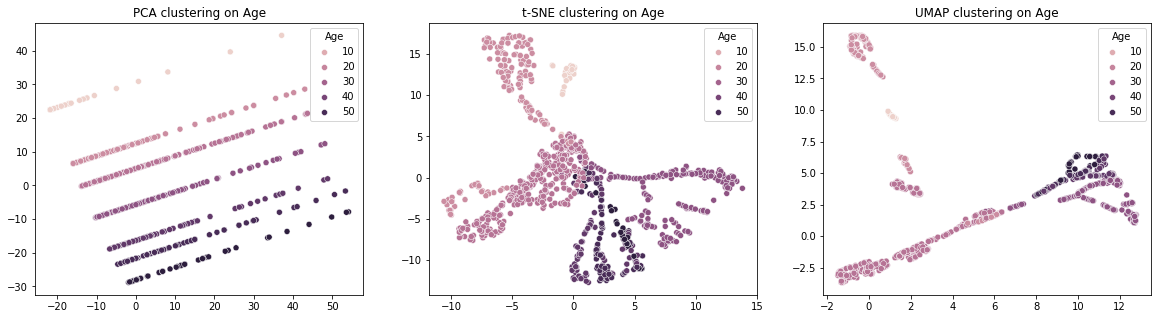

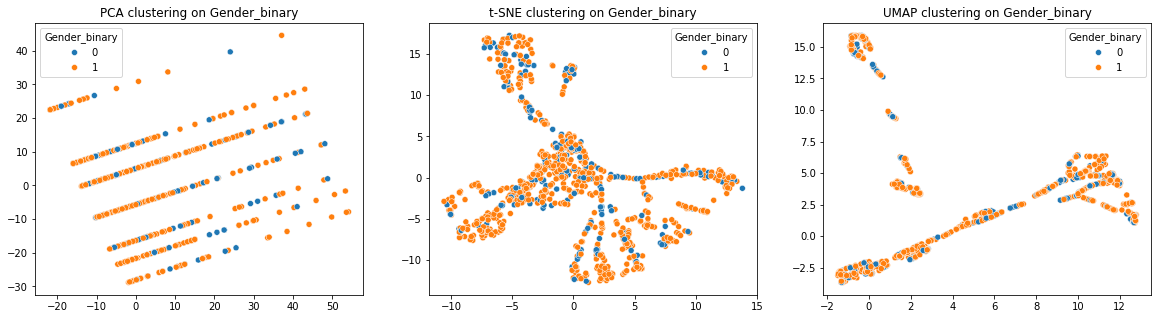

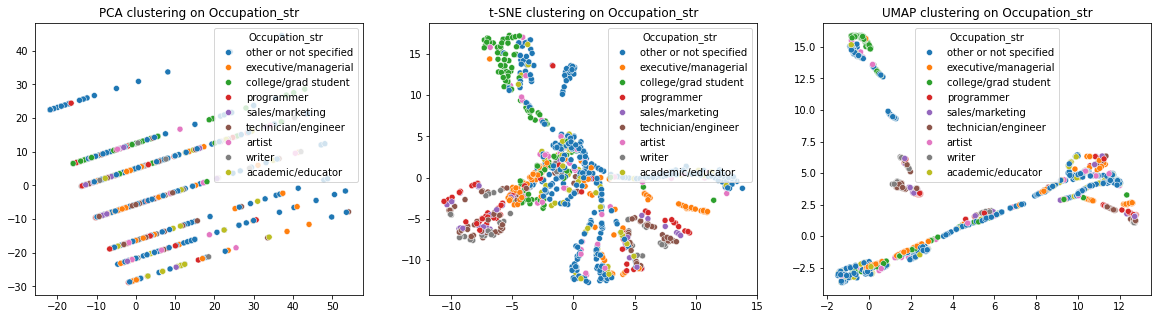

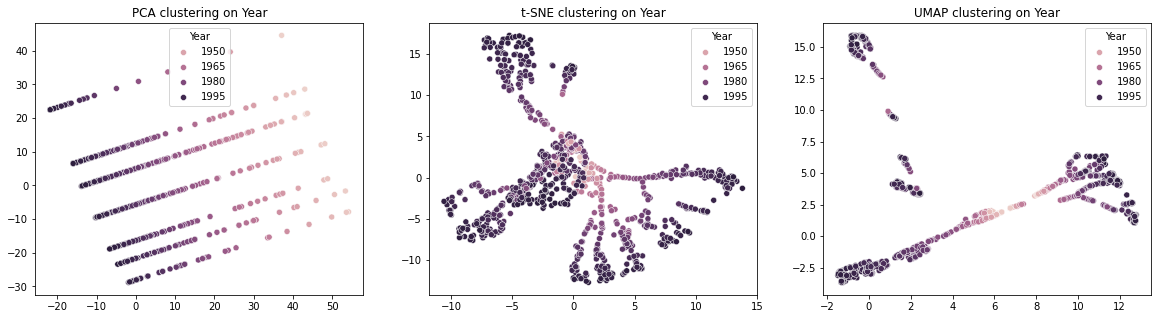

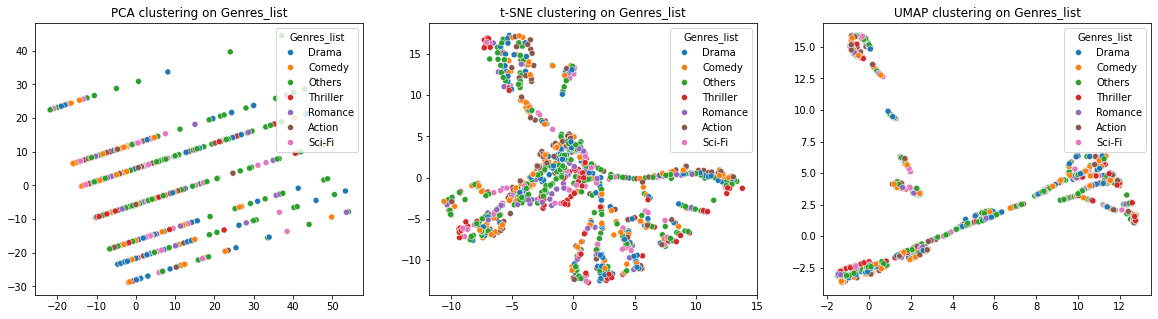

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder
# For users
# Choose the features you want to visualize, for instance, Age and Occupation
df=final_merged_df

df['Genres_list'] = df['Genres'].apply(lambda x: x.split('|'))

# Count the frequency of each genre
genre_counts = df.explode('Genres_list')['Genres_list'].value_counts()
occupation_counts = df['Occupation'].value_counts()

# Get the 10 least frequent genres
least_common_genres = genre_counts.nsmallest(12).index
least_common_occupations = occupation_counts.nsmallest(12).index

# Replace these genres with 'Others' in the DataFrame
df['Genres_list'] = df['Genres_list'].apply(lambda genres: ["Others" if genre in least_common_genres else genre for genre in genres])
df['Occupation'] = np.where(df['Occupation'].isin(least_common_occupations), 0, df['Occupation'])
print(least_common_occupations)
# Decoded occupations 
occupation_mapping = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}
df['Occupation_str'] = df['Occupation'].map(occupation_mapping)
# Regenerate the exploded DataFrame for visualization
exploded_df = df.explode('Genres_list')

label_encoder = LabelEncoder()
# Fit label encoder and return encoded labels
exploded_df['Genres_encoded'] = label_encoder.fit_transform(exploded_df['Genres_list'])
encoded_genres_subset = exploded_df.sample(n=100)

exploded_df['Year'] = exploded_df['Title'].str.extract('\((\d{4})\)')
exploded_df['Year'] = pd.to_numeric(exploded_df['Year'])
bins = [1980, 1990, 2000, 2010, 2020]
labels = [1980, 1990, 2000, 2010]
exploded_df['Decade'] = pd.cut(exploded_df['Year'], bins=bins, labels=labels, right=False)

# Male=1 female =0
exploded_df['Gender_binary'] = exploded_df['Gender'].apply(lambda x: 1 if x == 'M' else 0)

subset_df = exploded_df.sample(n=1000)
user_features = subset_df[['Rating','Age','Gender_binary','Occupation','Year', 'Genres_encoded']]

# For PCA
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features)

# For t-SNE
tsne = TSNE(n_components=3)
user_tsne = tsne.fit_transform(user_features)

# For UMAP
umap_model = umap.UMAP(n_components=3)
user_umap = umap_model.fit_transform(user_features)

# Plotting, take the strings
variables=['Age', 'Gender_binary','Occupation_str','Year', 'Genres_list']
for variable in variables:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    # Plot PCA
    sns.scatterplot(x=user_pca[:, 0], y=user_pca[:, 1], hue=subset_df[variable], ax=axs[0])
    axs[0].set_title(f'PCA clustering on {variable}')

    # Plot t-SNE
    sns.scatterplot(x=user_tsne[:, 0], y=user_tsne[:, 1], hue=subset_df[variable], ax=axs[1])
    axs[1].set_title(f't-SNE clustering on {variable}')

    # Plot UMAP
    sns.scatterplot(x=user_umap[:, 0], y=user_umap[:, 1], hue=subset_df[variable], ax=axs[2])
    axs[2].set_title(f'UMAP clustering on {variable}')

plt.show()



# Results Dimensionality Reduction


The outcome of the dimensionality reduction models doesn't provide distinct clusters as expected. However, certain trends can be observed, particularly in variables like the year of the movie's release and the age of the user. These variables display some clustering, potentially attributed to their numerical and ordinal nature and which can contain information in the clustering process.

PCA, in particular, doesn’t seem to make good use of the entire dimensional space available, as the figure shows linear alignment of data points. This contrasts with the other two models, t-SNE and UMAP, which show a more complex, non-linear distribution of data points in the 2-dimensional space. This suggests that while PCA may be limited by its linear methods, t-SNE and UMAP, being capable of capturing non-linear structures, could potentially offer more insightful visualizations.

The lack of clusters for the differet methods can be explained by the complex nature of the data. Features such as genre are very difficult to use for clustering as many movies contain characteristics of different genres causing overlapping clusters (data points belonging to different clusters). Furthermore the feature occupation has to many distinct values causing problems when showig clusters in a 2 dimennsional space.